# 경제 분석 및 예측과 데이터 지능 실습2.5: Store Sales Forecasting with neuralprophet

실습2에서 배운 내용을 적용해 봅니다.

APPENDIX: [Fourier Transform](https://www.youtube.com/watch?v=spUNpyF58BY), [Latent Space](https://www.youtube.com/watch?v=hZ4a4NgM3u0)

References:
- [Modern Time Series Forecasting Techniques](https://medium.com/dataman-in-ai/mastering-time-series-forecasting-from-classical-foundations-to-cutting-edge-applications-0-1b0ac3da3188)
- [Store-Sales-Time-Series-Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)
- [Kaggle-Notebook](https://www.kaggle.com/code/kutlukatalay/advanced-time-series-forecasting-with-prophet)

## What is Kaggle?

- 캐글은 세계에서 가장 큰 데이터 사이언스 커뮤니티이자, 연구기관/기업 등에서 상금을 걸고 데이터 분석을 의뢰하는 경연의 장입니다.
- 정형 데이터는 물론이고 오디오/이미지/텍스트 데이터를 활용하여 다양한 과제들이 주어집니다.
- 공학, 자연과학은 물론 경제학, 인문학과 관련된 다양한 경연이 기관의 니즈에 맞추어 실시간으로 열립니다.
- Kaggle을 통해 데이터를 제공하고 참여자는 주어진 데이터를 바탕으로 결과물을 출력해 csv로 저장하는 코드를 제출합니다.
- Kaggle 서버에서 코드가 돌아가고 평가기준에 맞추어 점수가 계산됩니다.
- 시계열 예측과 관련된 경연의 경우 대부분 RMSE, MAPE 등이 활용됩니다.

### 캐글의 'Store Sales Time Series Forecasting' 경연 링크는 아래와 같습니다.

링크: [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

설명:
- 에콰도르에서 2013년 1월 1일부터 2017년 8월 15일까지의 데이터를 바탕으로 이후 15일간의 매장-카테고리 별 판매량을 예측해야 합니다.
- 평가 척도는 아래와 같습니다(Root Mean Squared Log Error).

$$
\mathrm{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_{i}) - \log(1 + y_{i}))^{2}}
$$

그 외 데이터 설명, 변수 목록 등은 kaggle 사이트에 있습니다.

### 필요 모듈 및 데이터 로드

캐글에서 주어진 모든 데이터들을 읽어옵니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.api as sm
import gc

pio.renderers.default = "notebook"

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

train = pd.read_csv("../datasets/kaggle_store_sales/train.csv")
test = pd.read_csv("../datasets/kaggle_store_sales/test.csv")
stores = pd.read_csv("../datasets/kaggle_store_sales/stores.csv")
transactions = pd.read_csv("../datasets/kaggle_store_sales/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("../datasets/kaggle_store_sales/oil.csv")
holidays = pd.read_csv("../datasets/kaggle_store_sales/holidays_events.csv")

### 기초 데이터 탐색

In [2]:
train['date'] = pd.to_datetime(train['date'])
daily_sales = train.groupby('date')['sales'].sum().reset_index() # 일 별 매출 합계

fig = px.line(daily_sales, x='date', y='sales', title='Daily Sales Over Time')
fig.show()

### 가게 별 판매량 합계 및 월별 매출 합계 비교

In [3]:
store_type_sales = train.merge(stores, on='store_nbr')
store_type_performance = store_type_sales.groupby('type')['sales'].agg(['mean', 'std', 'count'])

In [4]:
store_type_analysis = store_type_sales.groupby('type').agg({
    'sales': ['mean', 'std', 'count', 'sum'],
    'store_nbr': 'nunique'}).round(2)

store_type_analysis.columns = ['avg_sales', 'std_sales', 'transaction_count', 'total_sales', 'store_count']
store_type_analysis = store_type_analysis.reset_index()

fig1 = go.Figure()

fig1.add_trace(go.Bar(name='Average Sales', x=store_type_analysis['type'],
    y=store_type_analysis['avg_sales'], marker_color='skyblue'))

fig1.add_trace(go.Bar(name='Sales Variability (Std)', x=store_type_analysis['type'],
    y=store_type_analysis['std_sales'], marker_color='lightcoral'))

fig1.update_layout(title='Store Type Performance Analysis', barmode='group',
    xaxis_title='Store Type', yaxis_title='Sales', showlegend=True)

fig1.show()

In [5]:
store_type_analysis['sales_per_store'] = (store_type_analysis['total_sales'] / 
                                         store_type_analysis['store_count']).round(2)
store_type_analysis['coefficient_of_variation'] = (store_type_analysis['std_sales'] / 
                                                 store_type_analysis['avg_sales'] * 100).round(2)


monthly_type_sales = store_type_sales.groupby([pd.Grouper(key='date', freq='M'),'type'])['sales'].mean().reset_index()

fig2 = px.line(monthly_type_sales, x='date', 
              y='sales', color='type',
              title='Monthly Average Sales by Store Type')

fig2.show()

### 유가와의 선형 회귀를 통한 비교 

In [6]:
oil['date'] = pd.to_datetime(oil['date'])
oil = oil.rename(columns={'dcoilwtico': 'oil_price'})
oil = oil.sort_values('date')

oil['oil_price'] = oil['oil_price'].ffill()

sales_oil = train.merge(oil, on='date', how='left')

daily_sales_oil = train.groupby('date')['sales'].sum().reset_index()
daily_sales_oil = daily_sales_oil.merge(oil, on='date', how='left')

fig = px.scatter(daily_sales_oil, x='oil_price', y='sales',
                trendline="ols", title='Correlation between Oil Prices and Total Sales')

fig.show()

In [7]:
corr = daily_sales_oil['oil_price'].corr(daily_sales_oil['sales'])

print("Correlation:", corr)

Correlation: -0.6903242663679009


### 거래량과 판매량의 관계 조사

In [8]:
transactions['date'] = pd.to_datetime(transactions['date'])
trans_sales = transactions.merge(train, on=['date', 'store_nbr'], how='inner')
trans_sales['sales_per_transaction'] = trans_sales['sales'] / trans_sales['transactions']

trans_sales = trans_sales.merge(stores, on='store_nbr', how='left')
spt_by_type = trans_sales.groupby('type')['sales_per_transaction'].agg([
    'mean', 'std', 'min', 'max'
]).round(2)

daily_metrics = trans_sales.groupby('date').agg({'sales': 'sum', 'transactions': 'sum'}).reset_index()

correlation = daily_metrics['sales'].corr(daily_metrics['transactions'])


fig = px.scatter(daily_metrics, x='transactions', y='sales',
                trendline="ols", title='Daily Sales vs Number of Transactions')

fig.show()

### 휴일에 따른 판매량 변화 분석

In [9]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays['year'] = holidays['date'].dt.year

sales_holidays = train.merge(holidays, on='date', how='left')

holiday_impact = sales_holidays.groupby('type')['sales'].agg(['mean', 'std', 'count']).round(2)

holiday_impact

mean      std   count
type                               
Additional 487.630 1414.270   67716
Bridge     446.750 1309.720    5346
Event      425.660 1401.020   99792
Holiday    358.430 1153.160  304722
Transfer   467.750 1373.060   16038
Work Day   372.160 1167.570    8910

In [10]:
sales_holidays = sales_holidays.merge(stores[['store_nbr', 'type']], 
                                    on='store_nbr', how='left',
                                    suffixes=('_holiday', '_store'))

store_holiday_interaction = sales_holidays[sales_holidays['type_holiday'].notna()].groupby(['type_store', 'type_holiday'])['sales'].mean().reset_index()

fig = px.bar(store_holiday_interaction, x='type_store', y='sales', color='type_holiday', 
             title='Average Sales by Store Type and Holiday Type', barmode='group',
             labels={'type_store': 'Store Type', 'sales': 'Average Sales', 'type_holiday': 'Holiday Type'})

fig.show()

### 트렌드 및 계절성에 대한 분석

- 일간
- 주간
- 월간

In [11]:
train['dayofweek'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month

daily_pattern = train.groupby('dayofweek')['sales'].mean().reset_index()
daily_pattern['dayofweek'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_pattern, x='dayofweek', y='sales',
             title='Average Daily Sales Pattern',
             labels={'sales': 'Average Sales', 'dayofweek': 'Day of Week'})

fig.show()

In [12]:
monthly_pattern = train.groupby('month')['sales'].mean().reset_index()
monthly_pattern['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = px.line(monthly_pattern, x='month', y='sales', title='Monthly Sales Seasonality',
              labels={'sales': 'Average Sales', 'month': 'Month'})

fig.show()

In [13]:
train['year'] = train['date'].dt.year
yearly_sales = train.groupby('year')['sales'].sum().reset_index()
yearly_growth = yearly_sales.copy()
yearly_growth['growth'] = yearly_growth['sales'].pct_change() * 100

fig = go.Figure()

fig.add_trace(go.Bar(x=yearly_growth['year'], y=yearly_growth['sales'], name='Total Sales'))

fig.add_trace(go.Scatter(x=yearly_growth['year'], y=yearly_growth['growth'], name='Growth Rate (%)', yaxis='y2'))

fig.update_layout(title='Yearly Sales and Growth Rate', yaxis=dict(title='Total Sales'),
    yaxis2=dict(title='Growth Rate (%)', overlaying='y', side='right'), showlegend=True)

fig.show()

In [14]:
type_colors = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'purple', 'E': 'orange'}

fig = go.Figure()

for _, store in stores.iterrows():
    fig.add_trace(go.Scatter(x=[store['city']], y=[store['state']],
        mode='markers', name=f'Store {store["store_nbr"]}',
        marker=dict(size=10, color=type_colors[store['type']], symbol='circle'),
        text=f'Store {store["store_nbr"]}<br>Type: {store["type"]}<br>City: {store["city"]}',
        hoverinfo='text'))

fig.update_layout(title='Store Network Distribution', xaxis_title='City', yaxis_title='State', showlegend=False)

fig.show()

## Neuralprophet 적용해 보기

- 전체 판매량에 대한 예측을 수행하였으므로 kaggle에서 요구하는 것과는 조금 다릅니다.

Complete DataFrame head:
          ds          y  oil_price
0 2013-01-01   2511.619     93.140
1 2013-01-02 496092.418     93.140
2 2013-01-03 361461.231     92.970
3 2013-01-04 354459.677     93.120
4 2013-01-05 477350.121        NaN
Columns: ['ds', 'y', 'oil_price']


<Axes: >

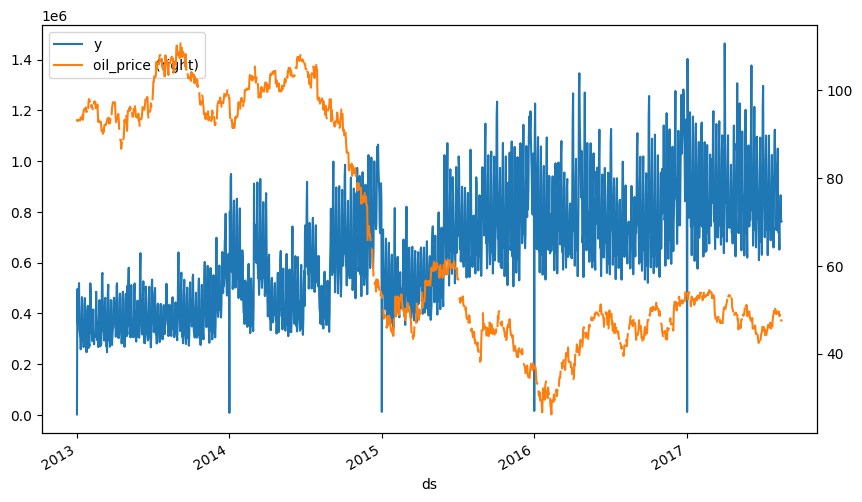

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
import warnings

# Suppress warnings and set logging level
warnings.filterwarnings("ignore")
set_log_level("ERROR")

# -------------------------------
# 1. Data Preparation: Create the "Perfect" DataFrame (using sales, oil_price, holiday flag)
# -------------------------------

# Load datasets (update paths as necessary)
train_data = pd.read_csv("../datasets/kaggle_store_sales/train.csv")
oil_data   = pd.read_csv("../datasets/kaggle_store_sales/oil.csv")

# Convert date columns to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Aggregate daily sales (we ignore onpromotion here)
df_sales = train_data.groupby('date').agg({'sales': 'sum'}).reset_index()
df_sales.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Merge oil data: rename oil column, fill missing values, and merge on date
oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
oil_data['oil_price'] = oil_data['oil_price'].ffill().bfill()
df_full = pd.merge(df_sales, oil_data[['date', 'oil_price']], left_on='ds', right_on='date', how='left')
df_full.drop(columns=['date'], inplace=True)

print("Complete DataFrame head:")
print(df_full.head())
print("Columns:", df_full.columns.tolist())

fig = df_full.plot(x = "ds", y = "y", figsize = (10,6))
df_full.plot("ds", "oil_price", secondary_y=True, ax=fig)

In [16]:
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags = 10,
    n_forecasts=50
)

m = m.add_country_holidays("EC")
m = m.add_lagged_regressor("oil_price", n_lags=10)

m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df_full, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
metrics.tail()

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/228 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

MAE_val   RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  reg_loss       MAE      RMSE  Loss  RegLoss
105 83233.977 113712.828     0.022        0.000    105       0.011     0.000 66417.078 88514.734 0.011    0.000
106 83325.156 113893.258     0.022        0.000    106       0.011     0.000 66103.820 88448.344 0.011    0.000
107 83388.234 114020.062     0.022        0.000    107       0.011     0.000 66327.898 88594.766 0.011    0.000
108 83042.438 113472.352     0.022        0.000    108       0.011     0.000 66089.914 88281.664 0.011    0.000
109 83337.281 114053.000     0.022        0.000    109       0.011     0.000 66330.758 88574.961 0.011    0.000

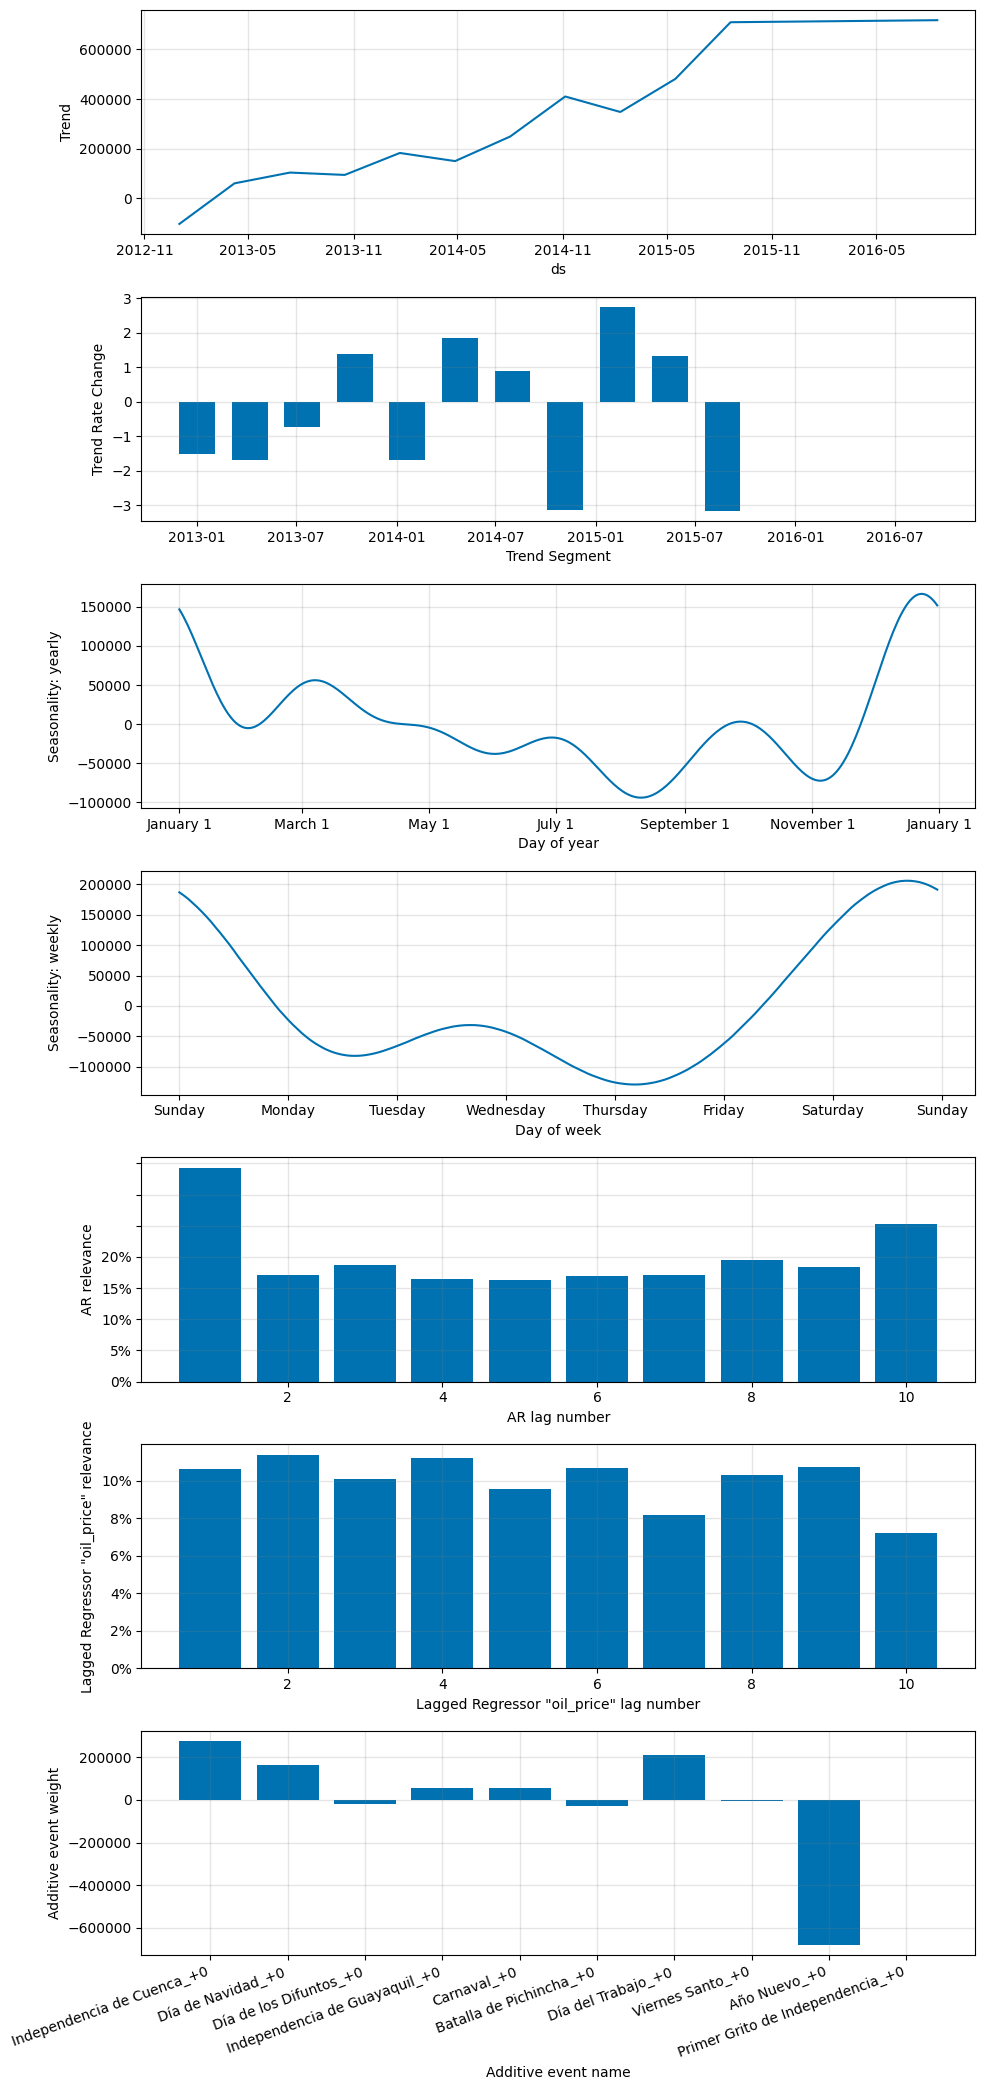

In [17]:
m.plot_parameters()

Predicting: |          | 0/? [00:00<?, ?it/s]

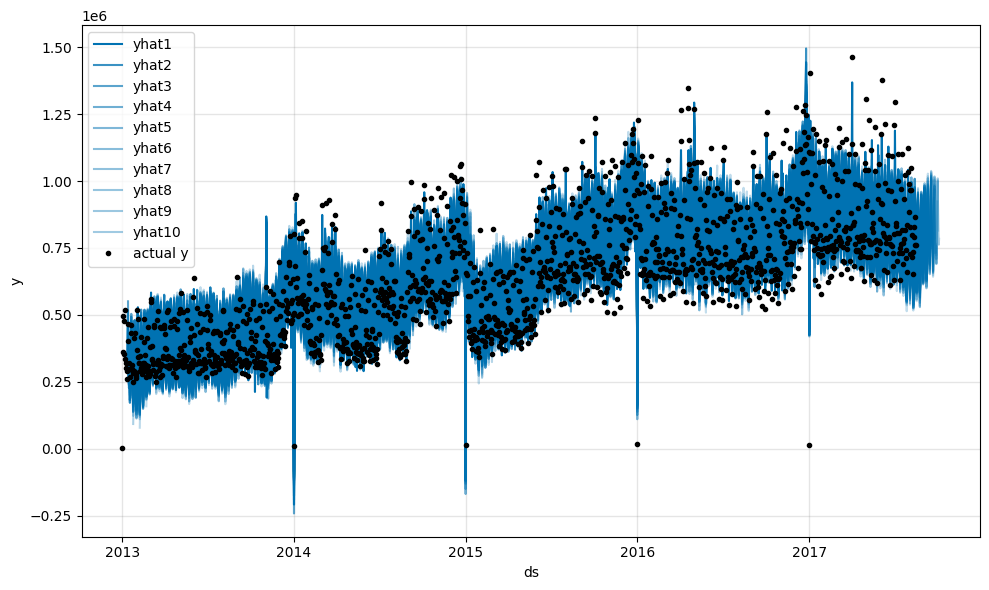

In [18]:
future = m.make_future_dataframe(
    df=df_full, 
    periods=50,
    n_historic_predictions=True, 
)

forecast = m.predict(future)

fig_forecast = m.plot(forecast)

## APPENDIX

### Fourier Transform


- 퓨리에 변환은 시간 공간에 있는 신호(주기성을 가진 시계열)을 주파수(frequency)공간으로 변환하여 보게 해 줌으로써 계절성 파악을 용이하게 함.
- 노이즈 제거, 특성 추출 등에 유용하게 사용.

\section{Definition}
시간에 대한 함수 $f(t)$에 대해 퓨리에 변환은 $\hat{f}(\omega)$ 이고 아래와 같이 정의:
$$
\hat{f}(\omega) = \int_{-\infty}^{\infty} f(t)\, e^{-i \omega t}\, dt
$$

- f(t)는 시간을 정의역으로 하는 함수
- $\hat{f}(\omega)$는 주파수(frequency)를 정의역으로 하는 함수

역변환은 아래와 같음:
$$
f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \hat{f}(\omega)\, e^{i \omega t}\, d\omega
$$

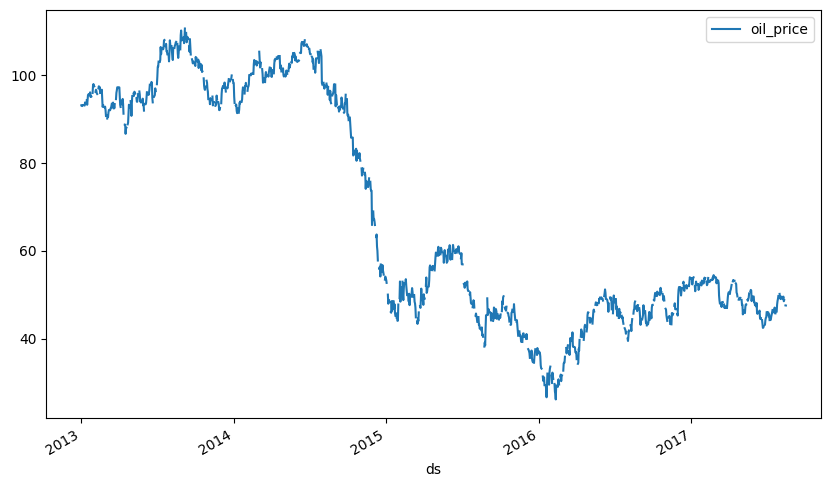

In [19]:
fig = df_full.plot(x = "ds", y = "oil_price", figsize = (10,6))

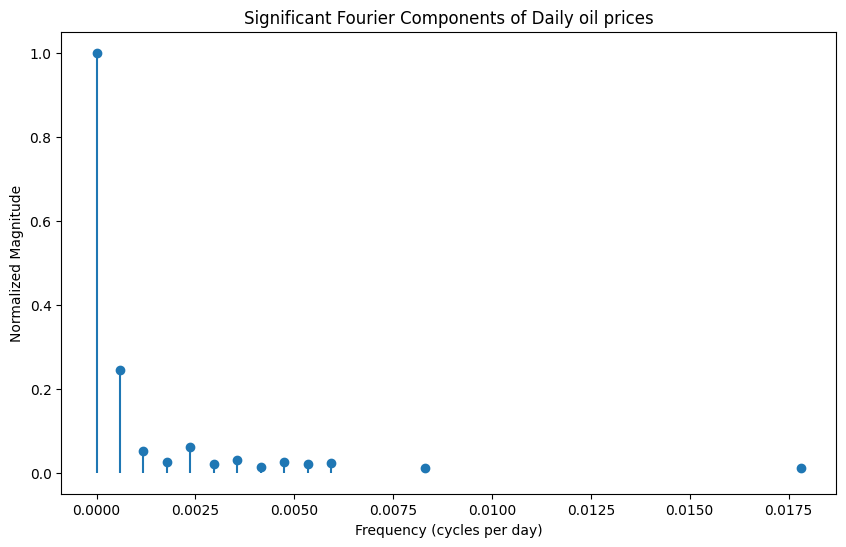

Significant Fourier Components:
   frequency  magnitude
0      0.000      1.000
1      0.000      0.240
2      0.000      0.060
3      0.000      0.050
4      0.000      0.030
5      0.000      0.030
6      0.000      0.020
7      0.000      0.020
8      0.010      0.020
9      0.010      0.020


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Load datasets (update paths as necessary)
oil_data   = pd.read_csv("../datasets/kaggle_store_sales/oil.csv")
# Convert date columns to datetime
oil_data['date'] = pd.to_datetime(oil_data['date'])
# Merge oil data: rename oil column, fill missing values, and merge on date
oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
oil_data['oil_price'] = oil_data['oil_price'].ffill().bfill()

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
df = oil_data[['date', 'oil_price']].copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['oil_price'] = df['oil_price'].astype(float)

# Aggregate daily sales and ensure every day is represented via resampling
daily_oil_price = df.groupby('date')['oil_price'].mean().reset_index()
daily_oil_price['date'] = pd.to_datetime(daily_sales['date'])
daily_oil_price = daily_oil_price.set_index('date').resample('D').sum().reset_index()

# -------------------------------
# 2. Compute the Fourier Transform
# -------------------------------
N = len(daily_sales)    # Total number of samples (days)
T = 1.0                 # Sampling interval (1 day)

# Convert the sales series to a NumPy array
y = daily_oil_price['oil_price'].values

# Compute FFT and corresponding frequencies (only positive frequencies)
Y = fft(y)
X = fftfreq(N, T)[:N//2]

# Compute normalized magnitude of the FFT
mag = 2.0/N * np.abs(Y[:N//2])
mag_norm = mag / np.max(mag)

# -------------------------------
# 3. Filter for Significant Frequencies
# -------------------------------
threshold = 0.01  # Components with magnitude below this are considered insignificant
significant = mag_norm > threshold
freqs = X[significant]
mags = mag_norm[significant]

# -------------------------------
# 4. Plot the Significant Fourier Components
# -------------------------------
plt.figure(figsize=(10, 6))
plt.stem(freqs, mags, basefmt=" ")  # Removed 'use_line_collection' for compatibility
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Normalized Magnitude")
plt.title("Significant Fourier Components of Daily oil prices")
plt.show()

# -------------------------------
# 5. Display the Results
# -------------------------------
result = pd.DataFrame({
    'frequency': freqs.round(2),
    'magnitude': mags.round(2)
}).sort_values('magnitude', ascending=False).reset_index(drop=True)
print("Significant Fourier Components:")
print(result[:10])


### Latent Space

- 팩터모형 등에 활용되는 개념으로, 실제 데이터보다 더 작은 차원에서 데이터를 표현하는 방법
- PCA, tSNE등의 알고리즘이 있으며 비 선형성을 모델링 할 수 있는 VAE도 존재

아래는 PCA를 활용하여 2개의 차원으로 sales, onpromotion, transactions, oil price 변수들을 표현하였습니다.

개별 색상은 클러스터(원본 데이터에서 유사도를 바탕으로 정의됨)를 표현합니다.

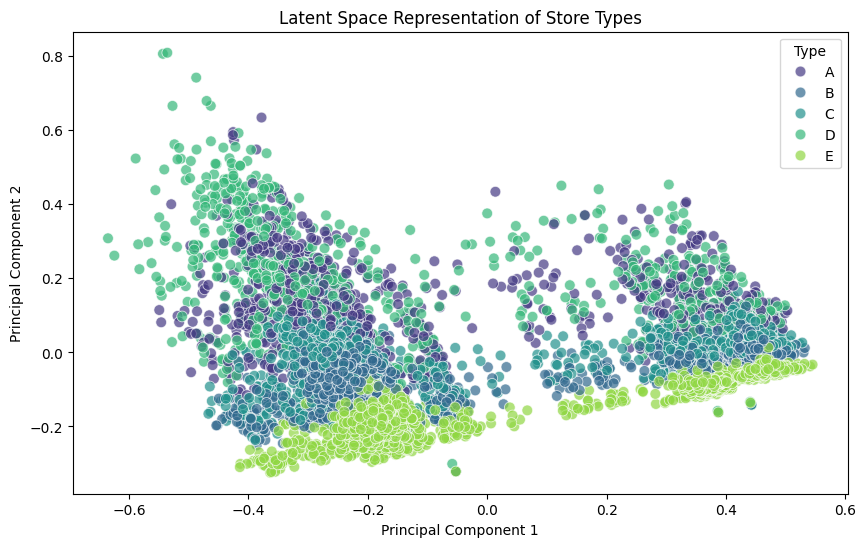

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 불러오기 및 전처리
train = pd.read_csv("../datasets/kaggle_store_sales/train.csv")
stores = pd.read_csv("../datasets/kaggle_store_sales/stores.csv")
oil = pd.read_csv("../datasets/kaggle_store_sales/oil.csv")
transactions = pd.read_csv("../datasets/kaggle_store_sales/transactions.csv")

# 날짜 형식 변환
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

# 매장 정보(매장 타입 등)와 합치기 위해 train과 stores 병합
train = pd.merge(train, stores, on='store_nbr', how='left')

# 날짜와 매장 타입별 집계: 예시로 날짜별 매출, onpromotion의 합계 계산
df_agg = train.groupby(['date', 'type']).agg({'sales': 'sum', 'onpromotion': 'sum'}).reset_index()
df_agg['date'] = pd.to_datetime(df_agg['date'])

# oil 데이터: oil_price (결측치는 보간)
oil = oil.rename(columns={'dcoilwtico': 'oil_price'})
oil['oil_price'] = oil['oil_price'].ffill().bfill()

# transactions 데이터: 날짜별 총 거래량 계산
df_trans = transactions.groupby('date')['transactions'].sum().reset_index()
df_trans['date'] = pd.to_datetime(df_trans['date'])

# 병합: df_agg에 oil과 transactions를 날짜 기준으로 병합
df_agg = pd.merge(df_agg, oil[['date', 'oil_price']], on='date', how='left')
df_agg = pd.merge(df_agg, df_trans, on='date', how='left')
df_agg = df_agg.dropna()

# 'date'를 ds로 변경
df_agg.rename(columns={'date': 'ds'}, inplace=True)

# 2. Feature Scaling: MinMaxScaler 사용
features = df_agg[['sales', 'onpromotion', 'oil_price', 'transactions']].values
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 3. PCA 수행 (2차원으로 압축)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
df_agg['PC1'] = pca_result[:, 0]
df_agg['PC2'] = pca_result[:, 1]

# 4. 결과 시각화 (매장 타입에 따라 색상 지정)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agg, x='PC1', y='PC2', hue='type', palette='viridis', alpha=0.7, s=60)
plt.title("Latent Space Representation of Store Types")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Type")
plt.show()
